## importing libraries

In [1]:
from keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot
import numpy as np
from  sklearn.model_selection import train_test_split

## Load MNIST dataset.

In [2]:
#loading
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
 
#shape of dataset
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))
 


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


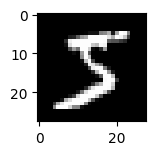

In [3]:
#plotting
for i in range(1):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

## Standardize your dataset

In [4]:
mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
std_train[std_train == 0] = 1e-9
X_train = (X_train - mean_train) / std_train

mean_test = np.mean(X_test, axis=0)
std_test = np.std(X_test, axis=0)
std_test[std_test == 0] = 1e-9
X_test = (X_test - mean_test) / std_test

X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((Y_train, Y_test), axis=0)

X_data = X_data.reshape(X_data.shape[0],-1)
print(X_data.shape)

(70000, 784)


## onehotercoder From scratch :-

In [5]:
class OneHotEncoder():
  def __init__(self):
    self.categories = None

  #  fit function is used to obtain the unique categories or classes present in the input data.
  # On the basis of this, I will be able to encode the data
  def fit(self , data):
    self.categories = sorted(list(set(data)))

  
  def transform(self , data):
    # in this condition, I'm just ensuring the there's no one can transform without a unique and sorted initialized categories
     if self.categories is None:
            raise ValueError("OneHotEncoder has not been fitted.")

     # Here I convert all the values in the data on the basis of the categories that were defined before, and one is placed under the category that classifies the current value, and zero otherwise
     encoded_data = []
     for value in data :
      one_hot_vector  = [1 if value == category else 0 for category in self.categories]
      encoded_data.append(one_hot_vector)

     return np.array(encoded_data)

  def fit_transform(self , data):
    self.fit(data)
    return self.transform(data)


In [6]:
encoder = OneHotEncoder()
y_data = y_data.reshape(-1,1)
y_data = y_data.flatten()
y_encoded = pd.DataFrame(encoder.fit_transform(y_data))
y_encoded

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
69995,0,0,1,0,0,0,0,0,0,0
69996,0,0,0,1,0,0,0,0,0,0
69997,0,0,0,0,1,0,0,0,0,0
69998,0,0,0,0,0,1,0,0,0,0


## Just Spliting the Data After Reshaping it :-

In [7]:
X_data = pd.DataFrame(X_data)
x_train , x_test ,y_train , y_test = train_test_split(X_data, y_encoded ,test_size=0.2,random_state=42)

 ## Implement a dynamic Neural Network from scratch. :-

In [8]:
class NeuralNetwork:
    def __init__(self, x, y, num_of_layers, size_of_layers):
        self.x = x
        self.y = y
        num_features = x.shape[0]

        self.num_of_layers = num_of_layers+1

        size_of_layers.insert(0,num_features)
        self.size_of_layers = size_of_layers
        
        self.weights = []
        self.biases = []
        self.outputs = []

        print(size_of_layers)
        # Initialize weights and biases for each layer
        for i in range(1, self.num_of_layers):
            weight_matrix = np.random.randn(self.size_of_layers[i], self.size_of_layers[i-1])
            bias_vector = np.random.randn(self.size_of_layers[i], 1)
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)


    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        sigmoid_x = self.sigmoid(x)
        return sigmoid_x * (1 - sigmoid_x)

    def mse_loss(self, y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))

    def forward_pass(self, x):
        self.outputs = []
        output = x

        # Forward pass through each layer
        for i in range(self.num_of_layers - 1):
            input_data = output
            weight_matrix = self.weights[i]
            bias_vector = self.biases[i]
            z = np.dot(weight_matrix, input_data) + bias_vector
            output = self.sigmoid(z)
            self.outputs.append((input_data, z, output))

        return output

    def backward_pass(self, x, y):
        num_samples = x.shape[1]
        deltas = []
        derivatives_w = []
        derivatives_b = []

        # Calculate the delta of the output layer
        input_data, z, output = self.outputs[-1]
        delta = (output - y) * self.sigmoid_derivative(z)
        deltas.append(delta)

        # Backward pass through each layer (except output layer)
        for i in range(self.num_of_layers - 2, 0, -1):
            input_data, z, output = self.outputs[i - 1]
            weight_matrix = self.weights[i]
            delta = np.dot(weight_matrix.T, deltas[-1]) * self.sigmoid_derivative(z)
            deltas.append(delta)

        # Calculate derivatives of weights and biases
        deltas.reverse()
        for i in range(self.num_of_layers - 1):
            input_data = self.outputs[i][0]
            delta = deltas[i]
            derivatives_w.append(np.dot(delta, input_data.T) / num_samples)
            derivatives_b.append(np.mean(delta, axis=1, keepdims=True))

        return derivatives_w, derivatives_b

    def update_weights(self, derivatives_w, derivatives_b, learning_rate):
        for i in range(self.num_of_layers - 1):
            self.weights[i] -= learning_rate * derivatives_w[i]
            self.biases[i] -= learning_rate * derivatives_b[i]

    def train(self, epochs, learning_rate):
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward_pass(self.x)

            # Backward pass
            derivatives_w, derivatives_b = self.backward_pass(self.x, self.y)

            # Update weights and biases
            self.update_weights(derivatives_w, derivatives_b, learning_rate)

            # Calculate and print loss
            loss = self.mse_loss(self.y, y_pred)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")


In [9]:
x_train=x_train.T.values
y_train=y_train.T.values

 Step 7: Test the code with different architectures
 1. Build NN with only 2 layers => 1 hidden layer and 1 output layer

In [10]:
nn1 = NeuralNetwork(x_train, y_train, 2, [20, 10])
nn1.train(100, 0.1)

[784, 20, 10]


<ipython-input-8-0524bd309bf3>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/100, Loss: 0.36463734331195236
Epoch 2/100, Loss: 0.36259563121360494
Epoch 3/100, Loss: 0.36056479924600915
Epoch 4/100, Loss: 0.358544888915502
Epoch 5/100, Loss: 0.35653597507622775
Epoch 6/100, Loss: 0.35453816539770994
Epoch 7/100, Loss: 0.3525515996740019
Epoch 8/100, Loss: 0.3505764489653926
Epoch 9/100, Loss: 0.34861291456356347
Epoch 10/100, Loss: 0.346661226771345
Epoch 11/100, Loss: 0.3447216434888474
Epoch 12/100, Loss: 0.34279444859883634
Epoch 13/100, Loss: 0.340879950145812
Epoch 14/100, Loss: 0.33897847830541217
Epoch 15/100, Loss: 0.3370903831434533
Epoch 16/100, Loss: 0.3352160321672054
Epoch 17/100, Loss: 0.33335580767525197
Epoch 18/100, Loss: 0.3315101039164991
Epoch 19/100, Loss: 0.32967932407339534
Epoch 20/100, Loss: 0.3278638770891028
Epoch 21/100, Loss: 0.3260641743630231
Epoch 22/100, Loss: 0.3242806263435403
Epoch 23/100, Loss: 0.32251363905090785
Epoch 24/100, Loss: 0.32076361056666275
Epoch 25/100, Loss: 0.31903092752864964
Epoch 26/100, Loss: 0.31

 2. Build NN with 3 layers => 2 hidden layers
 
 Where # of neurons in first layer < # of neurons in second layer and 1 output layer

In [11]:
nn2 = NeuralNetwork(x_train, y_train, 3, [5, 20, 10])
nn2.train(100, 0.1)

[784, 5, 20, 10]


<ipython-input-8-0524bd309bf3>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/100, Loss: 0.3168548041696878
Epoch 2/100, Loss: 0.30596308735051736
Epoch 3/100, Loss: 0.2952359466517837
Epoch 4/100, Loss: 0.2847285519305092
Epoch 5/100, Loss: 0.2744937632221013
Epoch 6/100, Loss: 0.2645801984893538
Epoch 7/100, Loss: 0.2550304690910622
Epoch 8/100, Loss: 0.24587971973071965
Epoch 9/100, Loss: 0.23715461086050305
Epoch 10/100, Loss: 0.22887284183651674
Epoch 11/100, Loss: 0.22104324298139705
Epoch 12/100, Loss: 0.21366638690295928
Epoch 13/100, Loss: 0.20673560638169008
Epoch 14/100, Loss: 0.20023827123614024
Epoch 15/100, Loss: 0.194157172023574
Epoch 16/100, Loss: 0.18847187809539817
Epoch 17/100, Loss: 0.18315997138871382
Epoch 18/100, Loss: 0.1781980954145509
Epoch 19/100, Loss: 0.17356279363752414
Epoch 20/100, Loss: 0.16923113852487345
Epoch 21/100, Loss: 0.16518117062748083
Epoch 22/100, Loss: 0.16139217686574228
Epoch 23/100, Loss: 0.15784484053005654
Epoch 24/100, Loss: 0.15452129444481524
Epoch 25/100, Loss: 0.15140510513931407
Epoch 26/100, Loss

 3. Build NN with 4 layers => 3 hidden layers
 
 Where # of neurons in first layer > # of neurons in second layer and 1 output layer

In [12]:
nn3 = NeuralNetwork(x_train, y_train, 3, [20,5, 10])
nn3.train(100, 0.1)

[784, 20, 5, 10]


<ipython-input-8-0524bd309bf3>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/100, Loss: 0.3497074767711691
Epoch 2/100, Loss: 0.3464961016106895
Epoch 3/100, Loss: 0.3433015646664084
Epoch 4/100, Loss: 0.34012703588436927
Epoch 5/100, Loss: 0.3369755543847343
Epoch 6/100, Loss: 0.33385000177391927
Epoch 7/100, Loss: 0.3307530786712348
Epoch 8/100, Loss: 0.3276872848046799
Epoch 9/100, Loss: 0.3246549029158458
Epoch 10/100, Loss: 0.32165798659735667
Epoch 11/100, Loss: 0.31869835207333025
Epoch 12/100, Loss: 0.3157775738287635
Epoch 13/100, Loss: 0.312896983901478
Epoch 14/100, Loss: 0.3100576745730626
Epoch 15/100, Loss: 0.30726050413486433
Epoch 16/100, Loss: 0.30450610536203526
Epoch 17/100, Loss: 0.30179489630253986
Epoch 18/100, Loss: 0.2991270929776163
Epoch 19/100, Loss: 0.2965027235936041
Epoch 20/100, Loss: 0.2939216438800274
Epoch 21/100, Loss: 0.2913835531929151
Epoch 22/100, Loss: 0.28888801105306366
Epoch 23/100, Loss: 0.28643445382397514
Epoch 24/100, Loss: 0.2840222112714326
Epoch 25/100, Loss: 0.2816505227843317
Epoch 26/100, Loss: 0.2793